# Part 2: Feature Engineering

## Imports and settings

In [42]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Re-Import the dataset


First, we'll import the cleaned dataset and check, if we retained the datatypes.

In [2]:
path = os.path.join(os.getcwd(), "../data/csv/cleaned_data.csv")
dtypes_path = os.path.join(os.getcwd(), '../data/auxiliary/cleaned_data_dtypes.json')

# load datatypes
with open(dtypes_path, 'r') as f:
    dtypes_dict = json.load(f)
    
# isolate datetime and non-datetime columns
datetime_cols = [col for col, dtype in dtypes_dict.items() if dtype == 'datetime64[ns]']
dtype_dict_nodate = {col: dtype for col, dtype in dtypes_dict.items() if dtype != 'datetime64[ns]'}

# load cleaned dataset using the types defined above
df = pd.read_csv(path, low_memory=False, parse_dates=datetime_cols, dtype=dtype_dict_nodate)
df.shape

(1581498, 36)

In [3]:
#create a dataframe to compare the original datatypes and the datatypes of the imported dataframe
dtypes_df = pd.DataFrame({
    'Saved Data Types': dtypes_dict,
    'Current Data Types': df.dtypes
})
dtypes_df

,Saved Data Types,Current Data Types
chat_handle,object,object
chat_name,object,object
chat_type,object,object
collection_time,datetime64[ns],datetime64[ns]
fwd_from_chat_handle,object,object
fwd_from_chat_id,Int64,Int64
fwd_from_user_name,object,object
is_fwd,bool,bool
is_group_elem,bool,bool
is_reply,bool,bool


## Feature 1: Strucutral Equivalence

1. We construct an adjacency matrix representing the frequency of forwarded messages from one chat to another in our dataset.

2. We correlate the rows of the matrix, ignoring diagonals to produce a correlation matrix. 

#### 1. Create the Chat/Feature Matrix

An adjacency matrix is a standard representation of a graph where each cell indicates the number of connections between nodes. In our case, the columns represent the source chats of messages, and the row indices represent the chats in our dataset.

Due to limitations in the data collection process, the current adjacency matrix does not capture all forward-based relationships between chats. Instead, it only reflects the incoming connections observed within the data collection timeframe.

To create a comprehensive adjacency matrix, we will:

1. Isolate Rows with forwarded messages


2. Construct the Adjacency Matrix


3. Add Chats with no forwarded messages

We'll start with isolating rows with forwarded messages and create the initial adjacency matrix.

In [4]:
# isolate rows that contain messages forwarded from a public chat
fwd_messages = df[~(pd.isna(df["fwd_from_chat_id"]))]

# Create the adjacency matrix 
adj_matrix = fwd_messages.pivot_table(
                            index='telegram_chat_id', 
                            columns='fwd_from_chat_id', 
                            aggfunc='size', # count the number of occurrences of each combination of telegram_chat_id and fwd_from_chat_id
                            fill_value=0) # fills all cells with no co-occurances of chat and source-chat with 0
adj_matrix.head()

fwd_from_chat_id,1000249388,1002276352,1002362600,1002489027,1003201003,1006487902,1006499585,1006503122,1008810857,1009650918,...,2239286766,2239304560,2240498869,2242503750,2242527103,2243517654,2244138096,2244914709,2247229261,2248949529
telegram_chat_id,,,,,,,,,,,,,,,,,,,,,
1100528049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1106758760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1127888562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129215099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129446959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we check, if we have chats without any forwarded messages in our dataset and if they are already in the matrix.

In [5]:
# group messages by chat they were sent in
grouped = df.groupby("telegram_chat_id")

# get the chat ids of all chats, that have 0 messages forwarded from public chats
def all_nans(series):
    return series.isna().all()
no_fwd_chats = grouped["fwd_from_chat_id"].apply(all_nans)
no_fwd_chats = no_fwd_chats[no_fwd_chats==True].index

# check if the Adjacency Matrix already contains the chats we identified
index_adj_matrix = adj_matrix.index
in_matrix = []
not_in_matrix = []

for index in no_fwd_chats:
    if index in (index_adj_matrix):
        in_matrix.append(index)
    else:
        not_in_matrix.append(index)
        
print(f"{len(in_matrix)}/{len(no_fwd_chats)} chats without forwarded messages are already in the matrix.")

0/13 chats without forwarded messages are already in the matrix.


Finally, we'll add rows for chats containing no forwarded messages to the matrix.

In [140]:
# create the adjacency matrix for non-forward chats
non_fwd_adj_matrix = pd.DataFrame(index=not_in_matrix, columns=adj_matrix.columns)
non_fwd_adj_matrix.fillna(0,inplace=True) # set all values to 0, as these chats have no connections.

# add them to the initial matrix
adj_matrix_combined = pd.concat([adj_matrix, non_fwd_adj_matrix], axis=0)
adj_matrix_combined

/var/folders/wv/j42m3p7n5jl51rggmnpn_6940000gn/T/ipykernel_20675/2543639150.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  non_fwd_adj_matrix.fillna(0,inplace=True) # set all values to 0, as these chats have no connections.


fwd_from_chat_id,1000249388,1002276352,1002362600,1002489027,1003201003,1006487902,1006499585,1006503122,1008810857,1009650918,...,2239286766,2239304560,2240498869,2242503750,2242527103,2243517654,2244138096,2244914709,2247229261,2248949529
1100528049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1106758760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1127888562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129215099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129446959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419385125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1527918321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1624340376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1695508103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Before moving on, we need to check if each chat is represented in our adjacency matrix.

In [141]:
initial_chat_count = df["telegram_chat_id"].nunique()
adj_matrix_chat_count = adj_matrix_combined.shape[0]
print(f"Number of chats in dataset: {initial_chat_count}")
print(f"Number of chats in Adjacency Matrix: {adj_matrix_chat_count}")

Number of chats in dataset: 351
Number of chats in Adjacency Matrix: 351


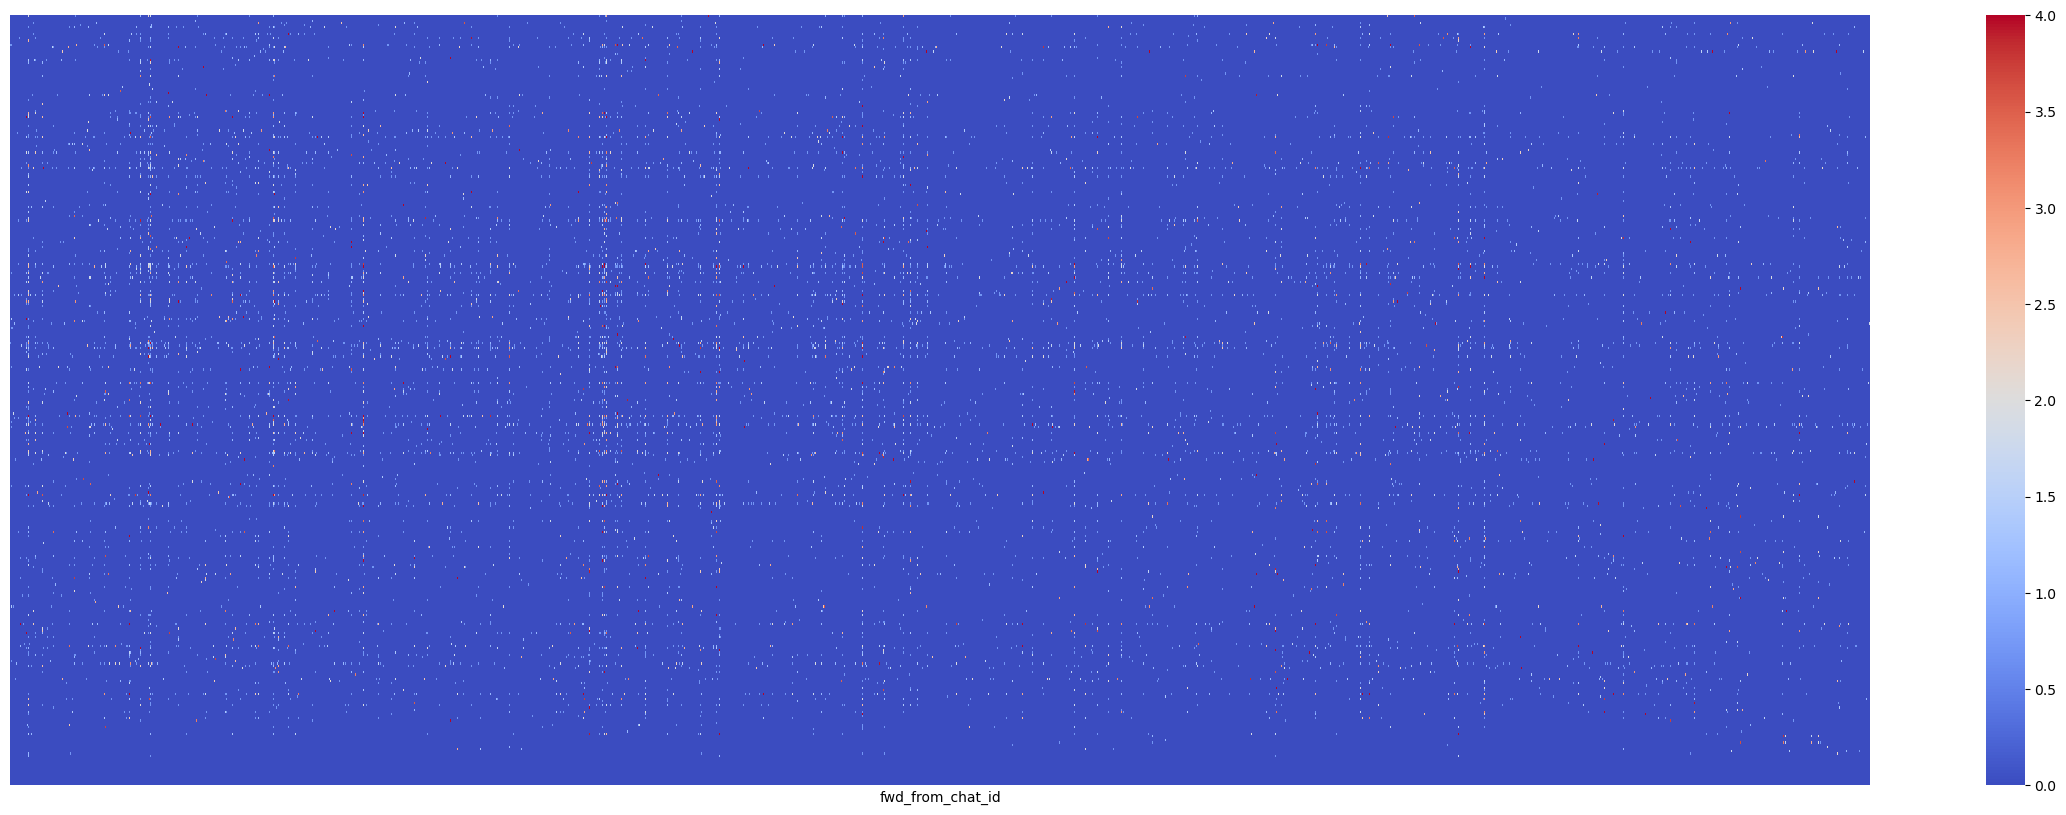

In [235]:
# Apply logarithmic scaling to the matrix
adj_matrix_log_scaled = np.log1p(adj_matrix_combined)  # np.log1p is log(x + 1) to handle zeros

# Convert back to DataFrame if needed
adj_matrix_log_scaled = pd.DataFrame(adj_matrix_log_scaled, 
                                     index=adj_matrix_combined.index, 
                                     columns=adj_matrix_combined.columns)


# Display the normalized adjacency matrix
plt.figure(figsize=(30, 10))
sns.heatmap(adj_matrix_log_scaled, annot=False, cmap='coolwarm', vmax=4)
plt.xticks([])
plt.yticks([])
plt.show()

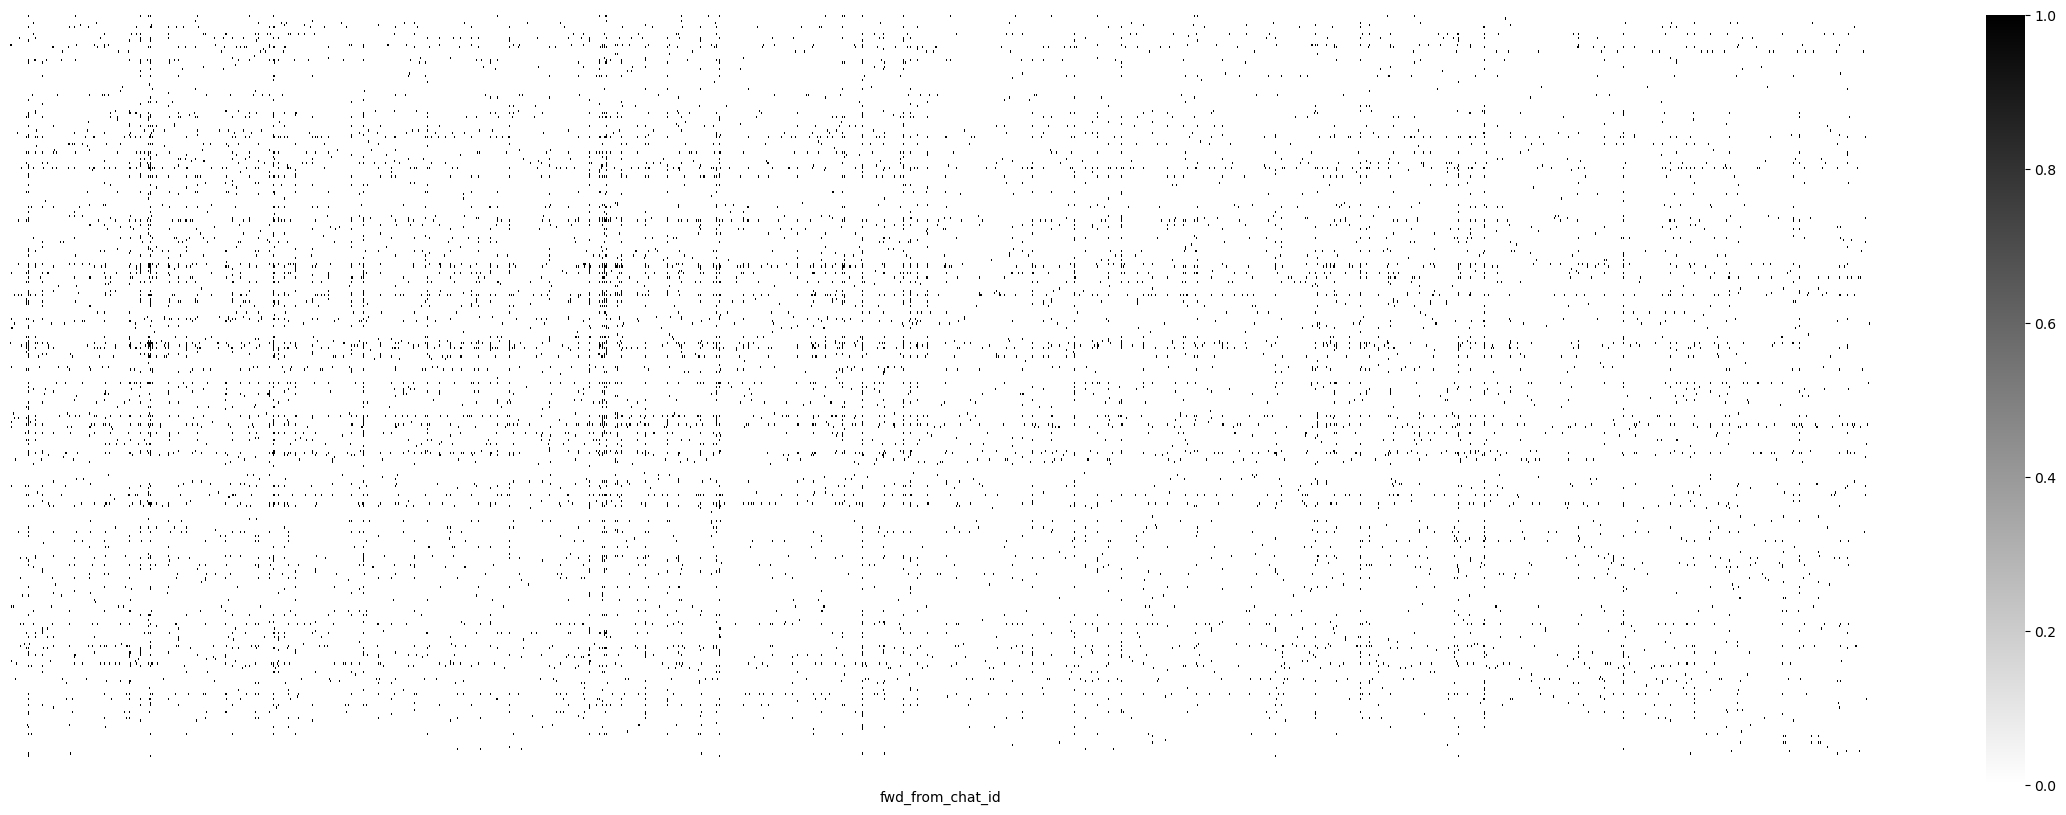

In [233]:
adj_matrix_one_hot = adj_matrix_combined.map(lambda x: 0 if x==0 else 1)

# Display the normalized adjacency matrix
plt.figure(figsize=(30, 10))
sns.heatmap(adj_matrix_one_hot, annot=False, cmap='gist_yarg')
plt.xticks([])
plt.yticks([])
plt.show()